In [2]:
#hide
from fastai2.vision.all import *
from utils import *

matplotlib.rc('image', cmap='Greys')

# Under the Hood: Training a Digit Classifier

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
path.ls()

(#3) [Path('labels.csv'),Path('valid'),Path('train')]

In [6]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [7]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [8]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [9]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [10]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [11]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## First Try: Pixel Similarity

In [12]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

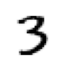

In [13]:
show_image(three_tensors[1]);

In [14]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [15]:
len(stacked_threes.shape)

3

In [16]:
stacked_threes.ndim

3

torch.Size([28, 28])


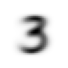

In [17]:
mean3 = stacked_threes.mean(0)
print(mean3.shape)
show_image(mean3);

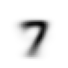

In [18]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

torch.Size([28, 28])
<class 'torch.Tensor'>


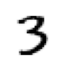

In [19]:
a_3 = stacked_threes[1]
print(a_3.shape)
print(type(a_3))
show_image(a_3);

In [20]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [21]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [22]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

In [23]:
??F.l1_loss

## Computing Metrics Using Broadcasting

In [24]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [25]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [26]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1290, 0.1223, 0.1380,  ..., 0.1337, 0.1132, 0.1097]),
 torch.Size([1010]))

In [27]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

In [28]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [29]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [30]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [31]:
accuracy_3s =      is_3(valid_3_tens).float().mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent (SGD)

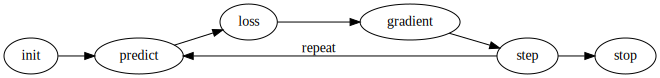

In [32]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

### Calculating Gradients

In [50]:
??Tensor.requires_grad_

In [60]:
??Tensor.backward

In [67]:
xt = tensor([3.,4.,10.]).requires_grad_()

print(xt)

def f(x): return (x**2).sum()

yt = f(xt)
print(yt)

yt.backward()

print(xt.grad)


tensor([ 3.,  4., 10.], requires_grad=True)
tensor(125., grad_fn=<SumBackward0>)
tensor([ 6.,  8., 20.])


### An End-to-End SGD Example

In [96]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

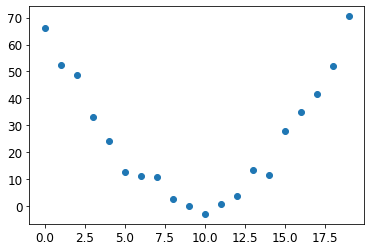

In [97]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [98]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [99]:
def mse(preds, targets): return ((preds-targets)**2).mean()

#### Step 1: Initialize the parameters

In [118]:
params = torch.randn(3).requires_grad_()
print(params)

tensor([-0.6890, -1.1267, -0.2858], requires_grad=True)


In [101]:
??Tensor.clone

In [119]:
#hide
orig_params = params.clone()
print(orig_params)

tensor([-0.6890, -1.1267, -0.2858], grad_fn=<CloneBackward>)


#### Step 2: Calculate the predictions

In [120]:
preds = f(time, params)

In [121]:
print(preds)

tensor([  -0.2858,   -2.1015,   -5.2952,   -9.8670,  -15.8168,  -23.1447,  -31.8506,  -41.9344,  -53.3964,  -66.2363,  -80.4543,  -96.0503, -113.0243, -131.3764, -151.1065, -172.2146, -194.7007,
        -218.5649, -243.8071, -270.4273], grad_fn=<AddBackward0>)


In [122]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

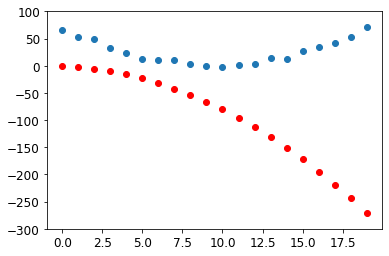

In [123]:
show_preds(preds)

#### Step 3: Calculate the loss

In [124]:
loss = mse(preds, speed)
loss

tensor(23408.1250, grad_fn=<MeanBackward0>)

#### Step 4: Calculate the gradients

In [125]:
loss.backward()
params.grad

tensor([-50601.8867,  -3261.9468,   -243.8370])

In [126]:
params.grad * 1e-5

tensor([-0.5060, -0.0326, -0.0024])

In [127]:
params

tensor([-0.6890, -1.1267, -0.2858], requires_grad=True)

#### Step 5: Step the weights. 

In [128]:
lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [129]:
preds = f(time,params)
mse(preds, speed)

tensor(4959.3188, grad_fn=<MeanBackward0>)

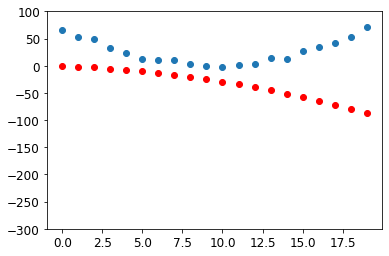

In [130]:
show_preds(preds)

In [131]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process 

In [132]:
for i in range(10): apply_step(params)

4959.31884765625
1468.2369384765625
807.6116943359375
682.595947265625
658.9336547851562
654.4505615234375
653.5968017578125
653.4298095703125
653.3927001953125
653.38037109375


In [133]:
#hide
params = orig_params.detach().requires_grad_()

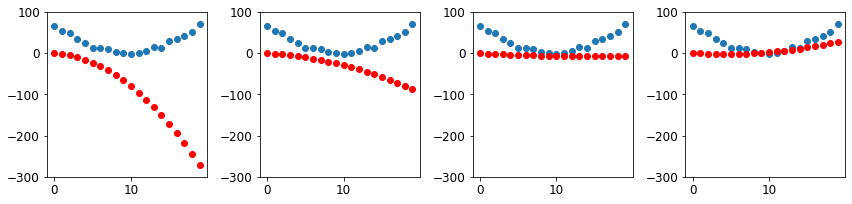

In [134]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

### Summarizing Gradient Descent

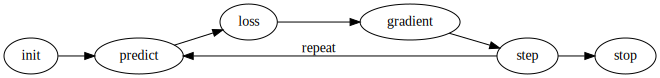

In [92]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

## The MNIST Loss Function

In [135]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [136]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

In [137]:
a = [1]
b = [0]
print(a*10 + b*5)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]


In [149]:
dset = list(zip(train_x,train_y))
print(dset[0][1])
x,y = dset[0]
x.shape,y.shape

tensor([1])


(torch.Size([784]), torch.Size([1]))

In [150]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [151]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [152]:
weights = init_params((28*28,1))
print(weights.shape)
print(weights[0])

torch.Size([784, 1])
tensor([-0.6788], grad_fn=<SelectBackward>)


In [153]:
bias = init_params(1)
print(bias.shape)
print(bias)

torch.Size([1])
tensor([-1.0935], requires_grad=True)


In [154]:
(train_x[0]*weights.T).sum() + bias

tensor([7.8296], grad_fn=<AddBackward0>)

In [155]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
print(train_x.shape, preds.shape)
preds

torch.Size([12396, 784]) torch.Size([12396, 1])


tensor([[ 7.8296],
        [ 9.1748],
        [-0.1391],
        ...,
        [20.1588],
        [ 8.4616],
        [15.7715]], grad_fn=<AddBackward0>)

In [156]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [False],
        ...,
        [False],
        [False],
        [False]])

In [157]:
corrects.float().mean().item()

0.44740238785743713

In [158]:
weights[0] *= 1.0001

In [159]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.44740238785743713

In [162]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [164]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [165]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [166]:
mnist_loss(prds,trgts)

tensor(0.4333)

In [167]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

### Sigmoid

In [168]:
def sigmoid(x): return 1/(1+torch.exp(-x))

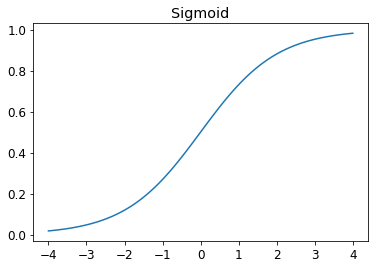

In [169]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [170]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### SGD and Mini-Batches

In [171]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  9,  6, 11]),
 tensor([13,  0,  1,  7, 10]),
 tensor([8, 4, 5, 2])]

In [173]:
??DataLoader

In [174]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

In [175]:
??L

In [176]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([ 4, 24, 15, 19,  6,  0]), ('e', 'y', 'p', 't', 'g', 'a')),
 (tensor([ 8, 18,  5, 16, 14, 21]), ('i', 's', 'f', 'q', 'o', 'v')),
 (tensor([25, 11,  7, 22, 13, 20]), ('z', 'l', 'h', 'w', 'n', 'u')),
 (tensor([23,  1,  9, 10, 17,  2]), ('x', 'b', 'j', 'k', 'r', 'c')),
 (tensor([ 3, 12]), ('d', 'm'))]

## Putting It All Together

In [177]:
weights = init_params((28*28,1))
bias = init_params(1)

In [179]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape, len(dset)

(torch.Size([256, 784]), torch.Size([256, 1]), 12396)

In [183]:
valid_dl = DataLoader(valid_dset, batch_size=256)
print(len(valid_dl), len(valid_dset))

8 2038


In [184]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [185]:
preds = linear1(batch)
preds

tensor([[  4.8588],
        [  1.8756],
        [-14.4004],
        [ -1.5447]], grad_fn=<AddBackward0>)

In [186]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.4912, grad_fn=<MeanBackward0>)

In [187]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0107), tensor([-0.0669]))

In [188]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [189]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0215), tensor([-0.1339]))

In [193]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0645), tensor([-0.4017]))

In [194]:
weights.grad.zero_()
bias.grad.zero_();

In [195]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [196]:
(preds>0.0).float() == train_y[:4]

tensor([[ True],
        [ True],
        [False],
        [False]])

In [197]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [198]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.5000)

In [199]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [200]:
validate_epoch(linear1)

0.5404

In [202]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.8343

In [204]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.974 0.974 0.974 0.974 0.974 0.974 0.9745 0.9745 0.975 0.975 0.9755 0.976 0.976 0.976 0.976 0.9765 0.9774 0.9774 0.9779 0.9779 

### Creating an Optimizer

In [205]:
linear_model = nn.Linear(28*28,1)

In [206]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

In [207]:
class BasicOptim:
    def __init__(self, params, lr): 
        self.params, self.lr = list(params), lr

    def step(self, *args, **kwargs):
        for p in self.params: 
            p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: 
            p.grad = None

In [208]:
opt = BasicOptim(linear_model.parameters(), lr)

In [209]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [210]:
validate_epoch(linear_model)

0.1524

In [211]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [212]:
train_model(linear_model, 20)

0.4932 0.9059 0.707 0.8799 0.9204 0.9379 0.9516 0.9594 0.9638 0.9663 0.9682 0.9702 0.9721 0.9751 0.9755 0.976 0.9775 0.978 0.9785 0.9785 

In [213]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8808 0.8179 0.9091 0.9321 0.9438 0.9541 0.9619 0.9653 0.9668 0.9697 0.9716 0.9731 0.9746 0.976 0.9765 0.9775 0.9775 0.978 0.9785 

In [214]:
dls = DataLoaders(dl, valid_dl)

In [215]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [216]:
learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636628,0.503450,0.495584,00:00
1,0.512373,0.191324,0.839549,00:00
2,0.188646,0.178050,0.842493,00:00
3,0.082987,0.105486,0.911678,00:00
4,0.044001,0.077256,0.933759,00:00
5,0.028762,0.062068,0.947988,00:00
6,0.022490,0.052575,0.955348,00:00
7,0.019697,0.046224,0.963690,00:00
8,0.018276,0.041748,0.965653,00:00
9,0.017421,0.038443,0.967125,00:00


## Adding a Nonlinearity

In [217]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [218]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

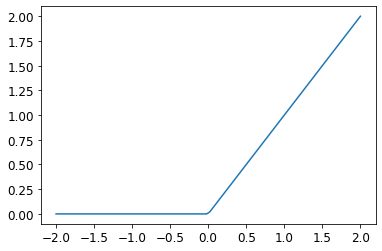

In [219]:
plot_function(F.relu)

In [220]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [221]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [222]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.344378,0.382295,0.540236,00:00
1,0.157957,0.233621,0.794406,00:00
2,0.085577,0.114893,0.917566,00:00
3,0.054849,0.076389,0.944553,00:00
4,0.040800,0.059420,0.958783,00:00
5,0.033771,0.050085,0.964671,00:00
6,0.029825,0.044247,0.966634,00:01
7,0.027314,0.040255,0.968106,00:00
8,0.025530,0.037356,0.969087,00:00
9,0.024163,0.035148,0.971050,00:00


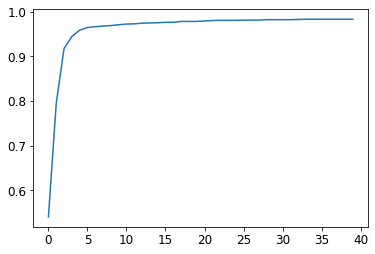

In [223]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [224]:
learn.recorder.values[-1][2]

0.983316957950592

### Going Deeper

In [225]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.078947,0.020027,0.995584,00:08
